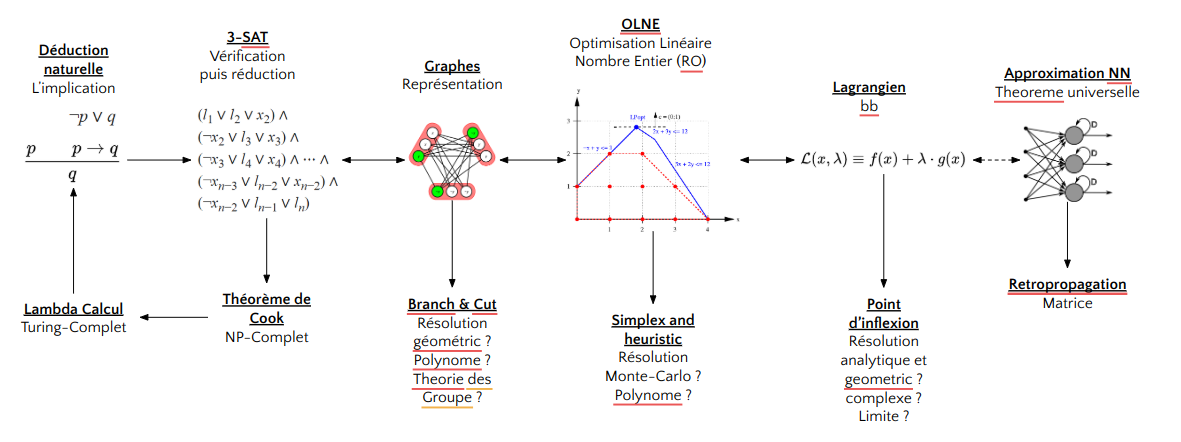

# Approximation du problème SAT par des réseaux de neurones

## 1. Déduction naturelle et arbre de preuve

Soit $\Gamma$ un ensemble de formules et $\phi$ une formule à prouver. Un arbre de preuve en déduction naturelle pour $\Gamma \vdash \phi$ est construit selon les règles d'inférence standard, e.g. :

$$
\frac{A \quad A \rightarrow B}{B} \quad (\text{Modus Ponens})
$$


## 2. Vérification et problème SAT

La vérification d'une preuve se réduit à vérifier la validité de chaque étape, ce qui peut être formulé comme un problème SAT :

$$
\text{SAT}(\phi) = \exists x_1, \ldots, x_n \in \{0,1\} : \phi(x_1, \ldots, x_n) = 1
$$


où $\phi$ est une formule booléenne sur $n$ variables.

## 3. Réduction à 3-SAT

Toute formule SAT peut être transformée en 3-SAT en temps polynomial. Pour une clause $C = (l_1 \vee l_2 \vee \ldots \vee l_k)$ avec $k > 3$, on introduit des variables auxiliaires :

$$
(l_1 \vee l_2 \vee y_1) \wedge (\neg y_1 \vee l_3 \vee y_2) \wedge \ldots \wedge (\neg y_{k-3} \vee l_{k-1} \vee l_k)
$$


### Théorème de Cook via le lambda-calcul

Le théorème de Cook peut être démontré en utilisant le lambda-calcul plutôt que les machines de Turing :

1. **Encodage des configurations** : Chaque configuration d'une machine non-déterministe est représentée par un terme du lambda-calcul.
2. **Transitions** : Les règles de transition sont exprimées par des formules booléennes en lambda-calcul.
3. **Formule globale** : On construit une formule $\phi$ exprimant l'existence d'une séquence valide de configurations menant à un état acceptant.
4. **Réduction** : On montre que toute instance d'un problème NP peut être traduite en une formule SAT équivalente en utilisant cet encodage.

Cette approche démontre la NP-complétude de SAT en utilisant le formalisme du lambda-calcul.

## 4. Représentation en graphes (Apparté)

Pour 3-SAT, on peut construire un graphe $G = (V, E)$ où :
- $V = \{x_1, \ldots, x_n, \neg x_1, \ldots, \neg x_n\}$
- $E = \{(l_i, l_j) : \exists \text{ clause } (l_i \vee l_j \vee l_k)\}$

Cette représentation est un exemple parmi d'autres schémas d'équivalence avec SAT, illustrant la versatilité du problème.

## 5. Formulation en OLNE

Le problème 3-SAT peut être formulé comme un problème d'optimisation :

$$
\begin{aligned}
\min_{x \in \{0,1\}^n} & \sum_{c \in \text{clauses}} (1 - \sum_{l \in c} l) \\
\text{s.t. } & x_i + \neg x_i = 1, \quad \forall i = 1,\ldots,n
\end{aligned}
$$


### Passage d'OLNE vers SAT

Pour transformer un problème d'optimisation linéaire et non linéaire (OLNE) en SAT :

1. **Discrétisation** : Les variables continues sont discrétisées avec une précision fixée.
2. **Encodage binaire** : Chaque variable discrète est encodée en binaire.
3. **Contraintes** : Les contraintes linéaires et non linéaires sont transformées en formules booléennes équivalentes.
4. **Fonction objectif** : La fonction objectif est encodée comme une série de comparaisons binaires.

Cette transformation permet de résoudre un problème OLNE en utilisant un solveur SAT.

## 6. Relaxation lagrangienne

On relaxe les contraintes $x_i + \neg x_i = 1$ en les intégrant dans la fonction objectif :

$$
L(x, \lambda) = \sum_{c \in \text{clauses}} (1 - \sum_{l \in c} l) + \sum_{i=1}^n \lambda_i(x_i + \neg x_i - 1)
$$


## 7. Optimisation d'un réseau de neurones

On peut approximer la solution du problème relaxé en utilisant un réseau de neurones artificiel (ANN) $f_\theta(x)$ minimisant la perte :

$$
\mathcal{L}(\theta) = \mathbb{E}_{x \sim \mathcal{D}}[L(f_\theta(x), \lambda)]
$$


où $\mathcal{D}$ est une distribution sur les instances SAT.

Le gradient de la perte par rapport aux paramètres $\theta$ du réseau est :

$$
\nabla_\theta \mathcal{L}(\theta) = \mathbb{E}_{x \sim \mathcal{D}}[\nabla_\theta L(f_\theta(x), \lambda)]
$$


On peut alors utiliser une descente de gradient stochastique pour optimiser les paramètres du réseau :

$$
\theta_{t+1} = \theta_t - \eta \nabla_\theta \mathcal{L}(\theta_t)
$$


où $\eta$ est le taux d'apprentissage.

## Conclusion

Cette approche permet d'approximer le problème SAT par un réseau de neurones artificiel en minimisant une fonction de perte dérivée de la relaxation lagrangienne. Bien que cette méthode ne garantisse pas une solution exacte, elle offre une heuristique potentiellement efficace pour des instances de SAT de grande taille, exploitant la capacité des réseaux de neurones à capturer des structures complexes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [ ]:
# Partie 1: Génération de clauses (inchangée)
def generate_clauses(num_variables, num_clauses):
    variable_indices = tf.random.uniform(
        shape=(num_clauses, 3),
        minval=0,
        maxval=num_variables,
        dtype=tf.int32
    )
    signs = tf.random.uniform(
        shape=(num_clauses, 3),
        minval=0,
        maxval=2,
        dtype=tf.int32
    ) * 2 - 1
    return tf.cast(variable_indices, tf.int32) * tf.cast(signs, tf.int32)

# Partie 2: Définition du modèle (inchangée)
class SATSolver(tf.keras.Model):
    def __init__(self, num_variables, hidden_units=[64, 32]):
        super(SATSolver, self).__init__()
        self.num_variables = num_variables
        self.input_layer = tf.keras.layers.Dense(hidden_units[0], activation='relu')
        self.hidden_layers = [tf.keras.layers.Dense(units, activation='relu') for units in hidden_units[1:]]
        self.output_layer = tf.keras.layers.Dense(num_variables, activation='sigmoid')

    def call(self, inputs):
        x = tf.reshape(inputs, [-1, inputs.shape[1] * inputs.shape[2]])
        x = self.input_layer(x)
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Partie 3: Fonction de coût lagrangienne (inchangée)
def lagrangian_loss(x, clauses, lambda_):
    num_variables = tf.shape(x)[0]
    clause_satisfaction = tf.reduce_max(
        tf.gather(tf.concat([1-x, x], axis=0), clauses + num_variables),
        axis=1
    )
    sat_loss = tf.reduce_sum(1.0 - clause_satisfaction)
    constraint_penalty = tf.reduce_sum(lambda_ * (x + (1-x) - 1))
    return sat_loss + constraint_penalty

# Partie 4: Configuration et entraînement (modifiée)
num_variables = 10
num_clauses = 50
clauses = generate_clauses(num_variables, num_clauses)
model = SATSolver(num_variables)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lambda_ = tf.Variable(initial_value=tf.ones(num_variables), trainable=True)

@tf.function
def train_step(clauses):
    with tf.GradientTape() as tape:
        predictions = model(tf.expand_dims(clauses, 0))
        loss = lagrangian_loss(predictions[0], clauses, lambda_)

    gradients = tape.gradient(loss, model.trainable_variables + [lambda_])
    optimizer.apply_gradients(zip(gradients[:len(model.trainable_variables)], model.trainable_variables))

    # Mise à jour manuelle de lambda_
    lambda_.assign_sub(0.001 * gradients[-1])

    return loss

# Boucle d'entraînement
num_epochs = 1000
for epoch in range(num_epochs):
    loss = train_step(clauses)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Partie 5: Évaluation (inchangée)
final_prediction = model(tf.expand_dims(clauses, 0))
print("Prédiction finale:", final_prediction.numpy().squeeze())
print("Valeur de lambda:", lambda_.numpy())

def check_satisfaction(prediction, clauses):
    clause_satisfaction = tf.reduce_max(
        tf.gather(tf.concat([1-prediction, prediction], axis=0), clauses + num_variables),
        axis=1
    )
    return tf.reduce_mean(clause_satisfaction)

satisfaction = check_satisfaction(final_prediction[0], clauses)
print(f"Taux de satisfaction des clauses: {satisfaction.numpy()*100:.2f}%")


Epoch 0, Loss: 7.660083770751953
Epoch 100, Loss: 5.000328063964844
Epoch 200, Loss: 5.000127792358398
Epoch 300, Loss: 5.000060081481934
Epoch 400, Loss: 5.000032901763916
Epoch 500, Loss: 5.0000200271606445
Epoch 600, Loss: 5.00001335144043
Epoch 700, Loss: 5.000009536743164
Epoch 800, Loss: 5.000006675720215
Epoch 900, Loss: 5.000004768371582
Prédiction finale: [1.0000000e+00 9.9999994e-01 9.9998683e-01 2.3013598e-11 7.3033306e-08
 4.6198321e-09 1.0000000e+00 9.9999750e-01 8.7958654e-08 1.3514772e-07]
Valeur de lambda: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Taux de satisfaction des clauses: 90.00%
